In [1]:
import pickle
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, ConcatDataset
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import mne
import copy

In [2]:
SEED = 0
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available(): torch.cuda.manual_seed_all(SEED)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

##### load trained model

In [3]:
class EEG_CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(18, 32, 3, padding=1); self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1); self.bn2 = nn.BatchNorm2d(64)
        self.pool  = nn.MaxPool2d(2)
        self.fc1   = nn.Linear(64*7*7, 256); self.fc2 = nn.Linear(256,128); self.fc3 = nn.Linear(128,2)
    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x)); x = F.relu(self.fc2(x))
        return self.fc3(x)


In [26]:
model = EEG_CNN().to(device)
state = torch.load('../result/BD_MDD/DL_result/cnn_model/cnn_final_model_test.pth', map_location=device)
model.load_state_dict(state); model.eval()

C:\Users\NESS-Kuan\AppData\Local\Temp\ipykernel_92520\644249715.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load('../result/BD_MDD/DL_result/cnn_model/

EEG_CNN(
  (conv1): Conv2d(18, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=3136, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=2, bias=True)
)

In [27]:
def vector_to_mat(vector, n=29):
    mat = np.zeros((n,n), float)
    triu = np.triu_indices(n,1)
    mat[triu] = vector; mat[(triu[1],triu[0])] = vector
    np.fill_diagonal(mat,1)
    return mat

In [28]:
bands = ['delta','theta','alpha','betalow','betahigh','gamma']
def build_tensor(subj, coh, pli, ste):
    mats=[]
    for b in bands: mats.append(vector_to_mat(coh[subj][b]))
    for b in bands: mats.append(vector_to_mat(pli[subj][b]))
    for b in bands:
        m = ste[subj][b].copy(); np.fill_diagonal(m,1); mats.append(m)
    return np.stack(mats,axis=2)

In [29]:
with open('../data/COH/BD_coh_data.pkl','rb') as f: BD_coh=pickle.load(f)
with open('../data/PLI/BD_pli_data.pkl','rb') as f: BD_pli=pickle.load(f)
with open('../data/STE/BD_ste_data.pkl','rb') as f: BD_ste=pickle.load(f)
with open('../data/COH/MDD_coh_data.pkl','rb') as f: MDD_coh=pickle.load(f)
with open('../data/PLI/MDD_pli_data.pkl','rb') as f: MDD_pli=pickle.load(f)
with open('../data/STE/MDD_ste_data.pkl','rb') as f: MDD_ste=pickle.load(f)

BD_subjs = sorted(BD_coh.keys()); MDD_subjs = sorted(MDD_coh.keys())
train_bd, train_mdd = BD_subjs[:45], MDD_subjs[:45]

enum_mods = ['COH']*6 + ['PLI']*6 + ['STE']*6
chan_labels = [f"{m}_{b}" for m,b in zip(enum_mods*1, bands*3)]

In [30]:
ds_bd = [(build_tensor(s,BD_coh,BD_pli,BD_ste),0) for s in train_bd]
ds_mdd = [(build_tensor(s,MDD_coh,MDD_pli,MDD_ste),1) for s in train_mdd]
from torch.utils.data import TensorDataset
full = ds_bd + ds_mdd
class EEGDataset(Dataset):
    def __init__(self,data): self.data=data
    def __len__(self): return len(self.data)
    def __getitem__(self,i): X,y=self.data[i]; return torch.tensor(X,dtype=torch.float32).permute(2,0,1), y
loader = DataLoader(EEGDataset(full), batch_size=1)


##### saliency calculation

In [31]:
saliency_sum = np.zeros((18,29,29), float); n=0
for X,y in loader:
    X = X.to(device); X.requires_grad_()
    out = model(X); score = out[0,y]
    model.zero_grad(); score.backward()
    grad = X.grad[0].cpu().detach().numpy()
    saliency_sum += np.abs(grad); n+=1
saliency_avg = saliency_sum / n

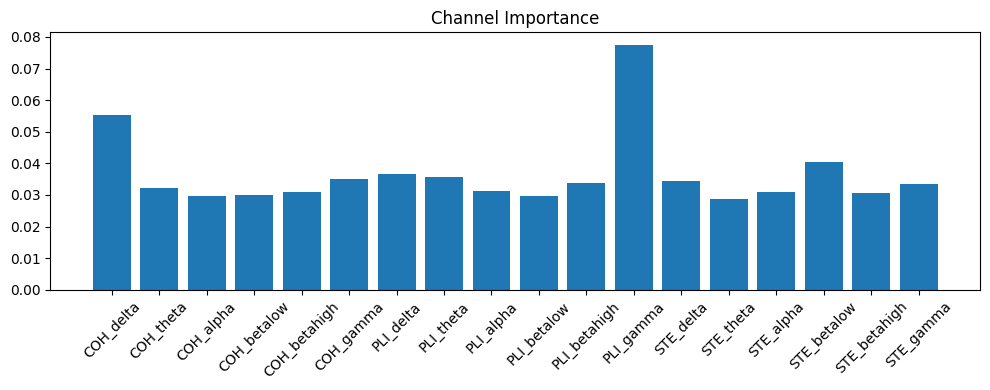

In [32]:
importance = saliency_avg.mean(axis=(1,2))
plt.figure(figsize=(10,4))
plt.bar(chan_labels, importance)
plt.xticks(rotation=45); plt.title('Channel Importance')
plt.tight_layout(); plt.show()


##### heatmap

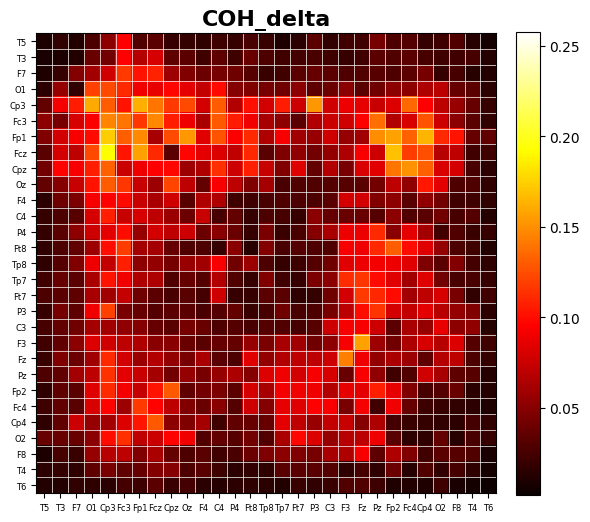

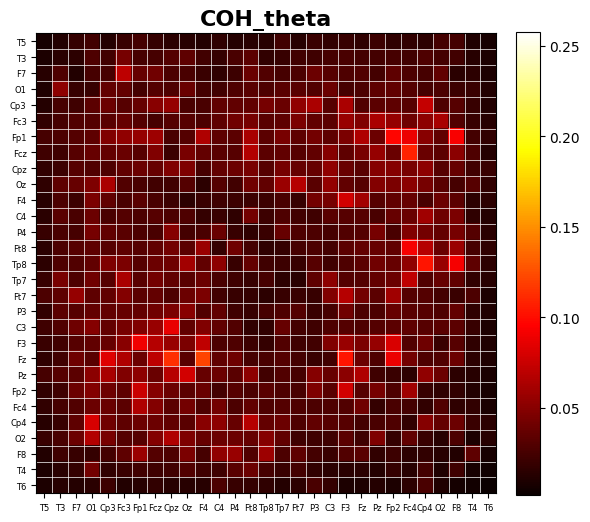

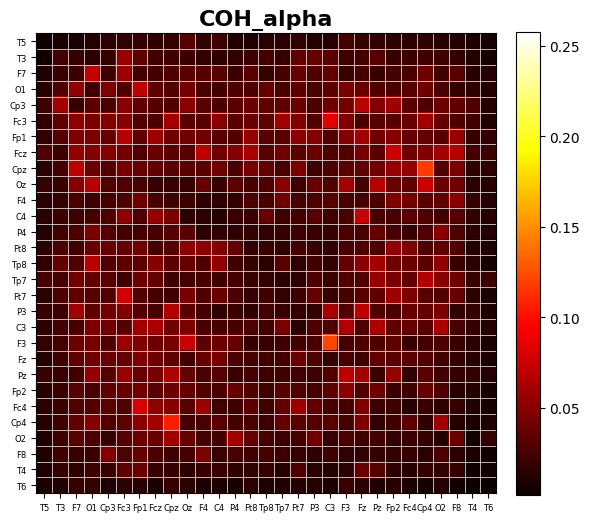

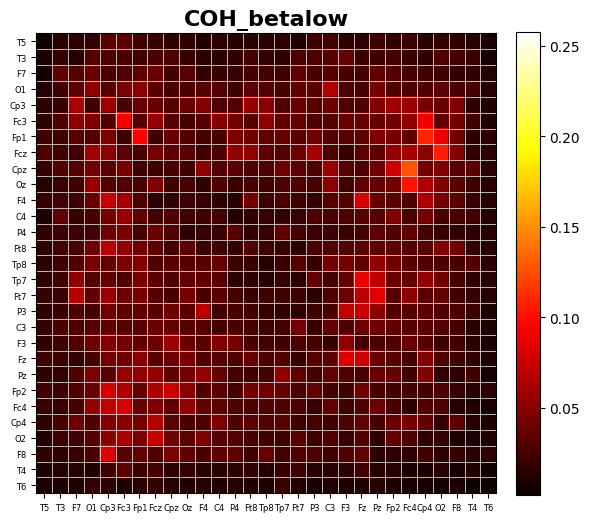

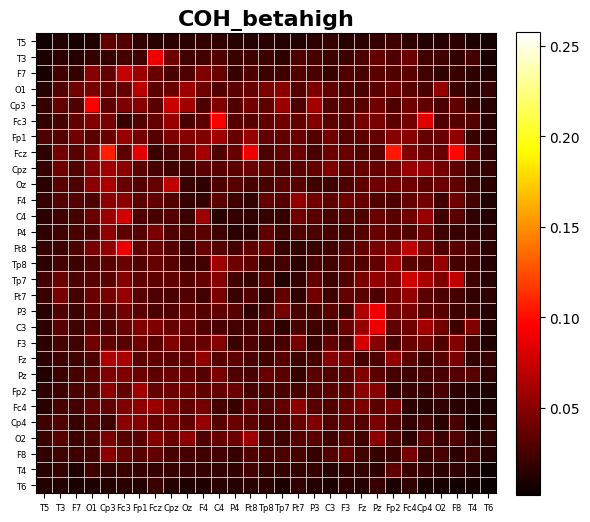

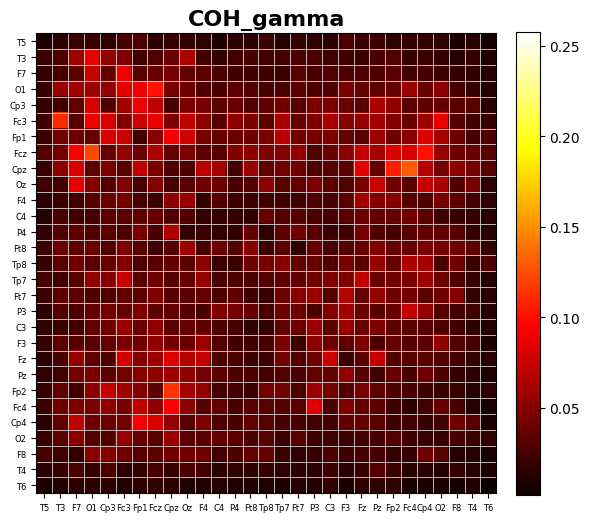

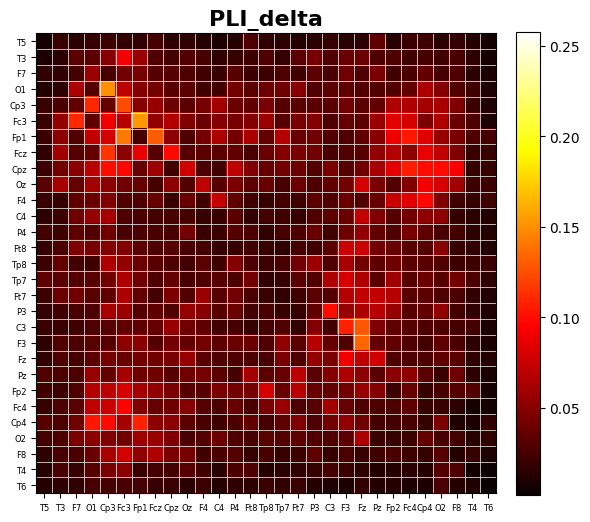

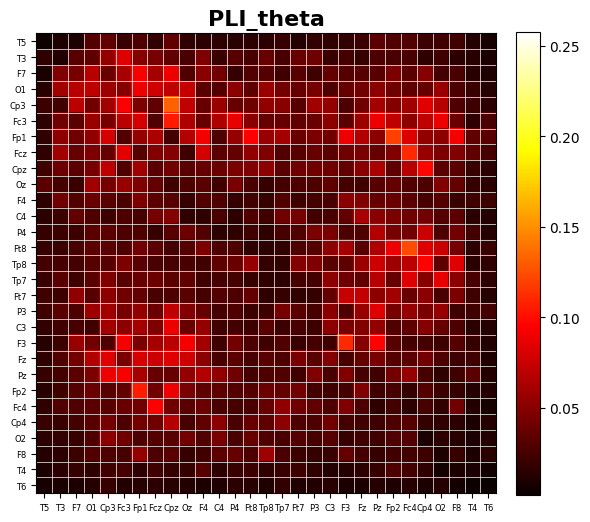

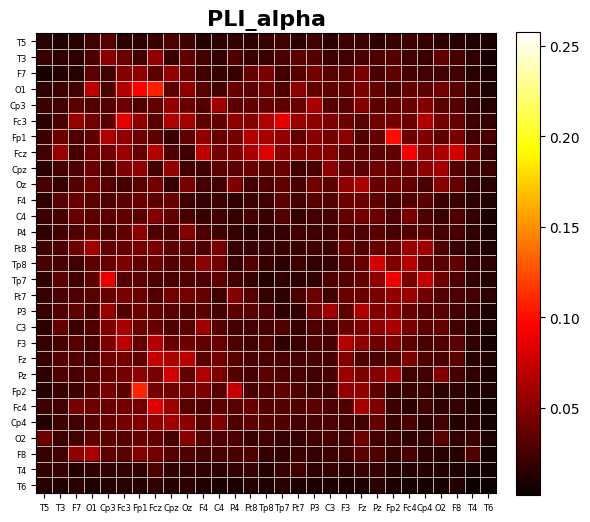

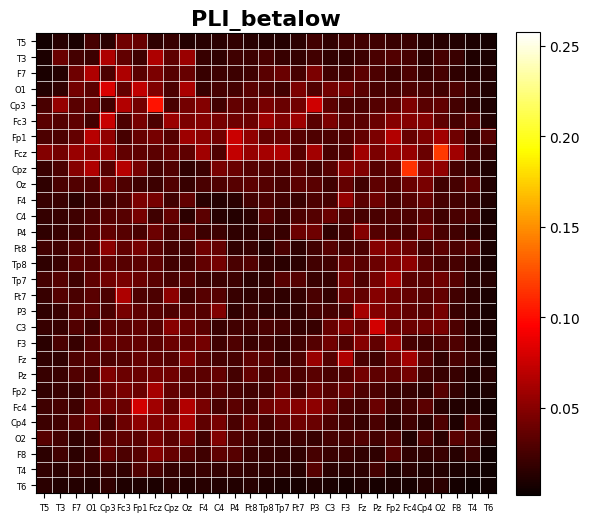

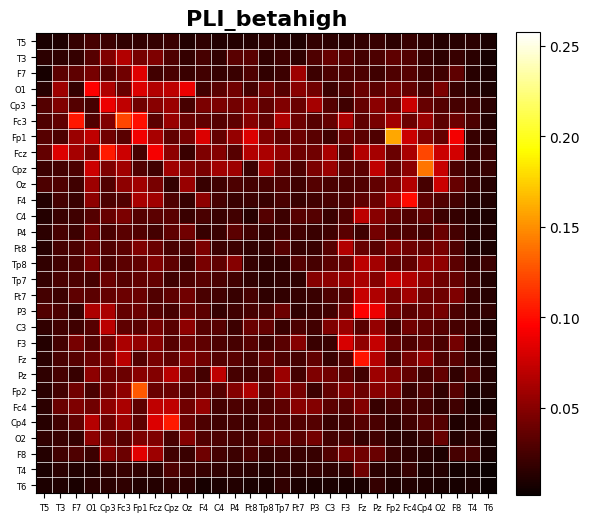

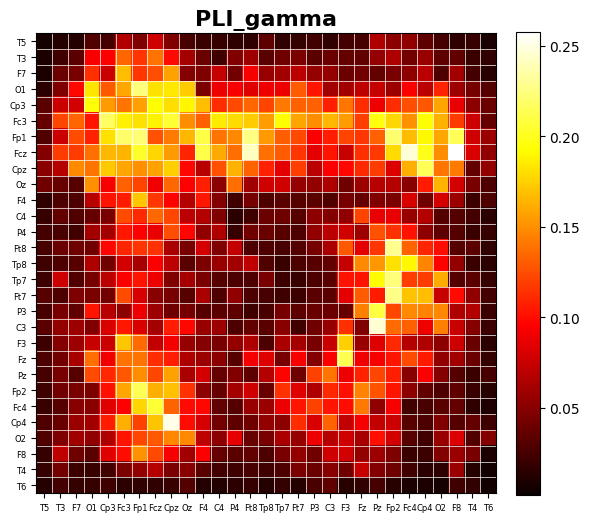

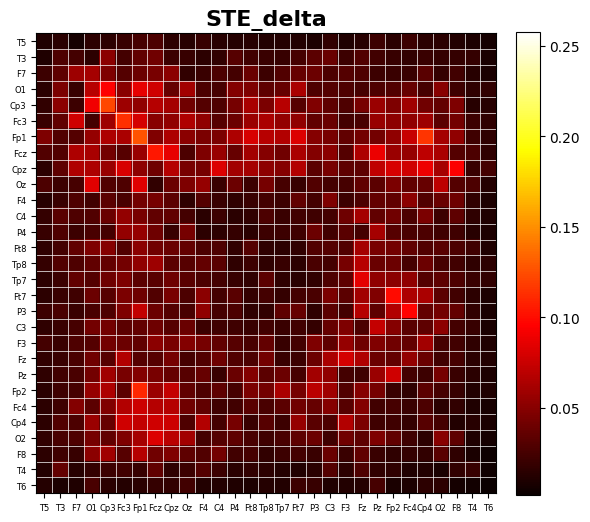

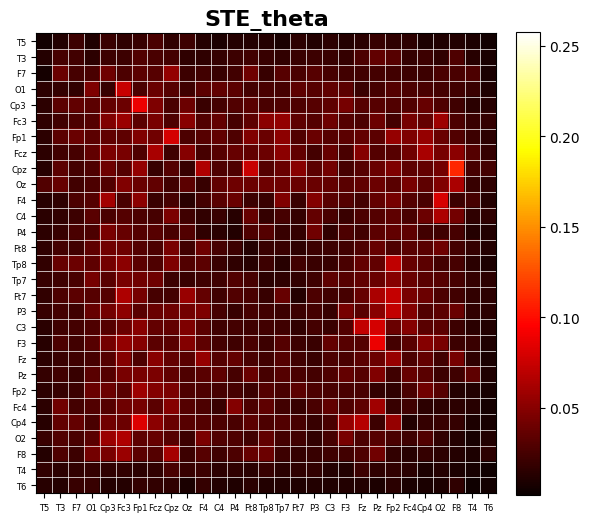

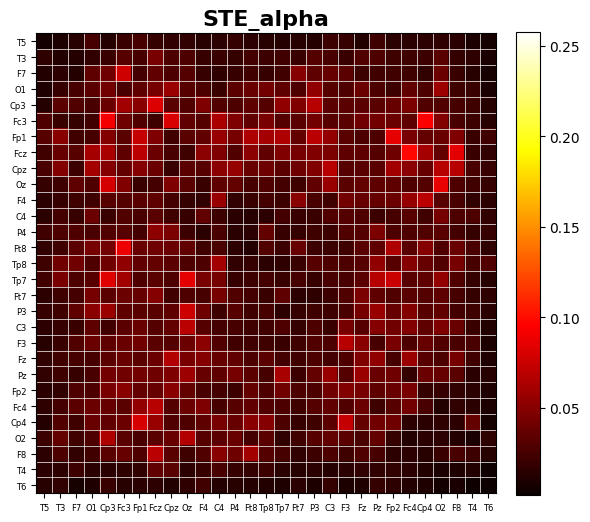

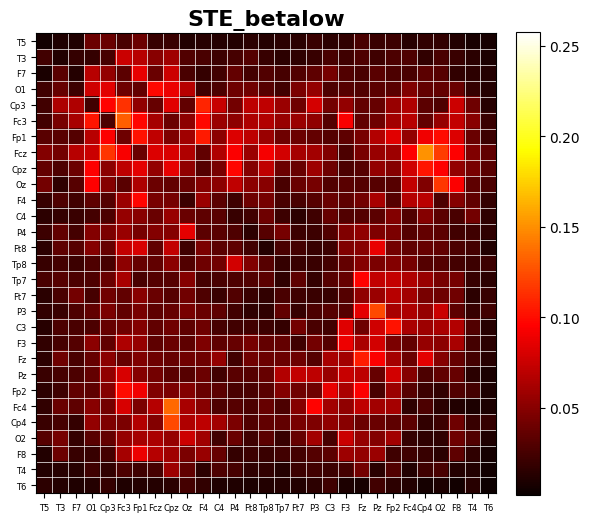

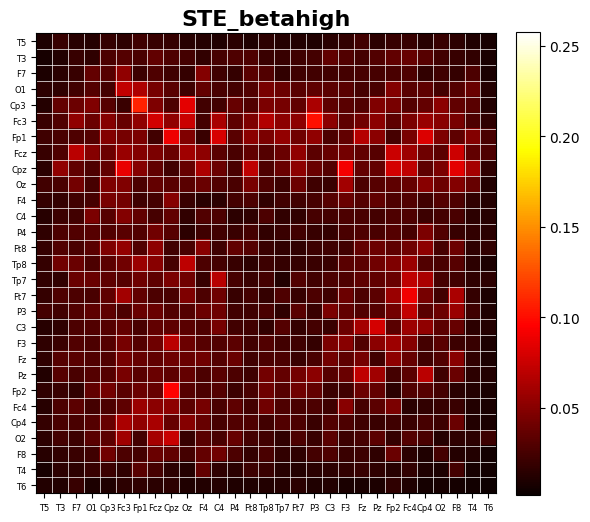

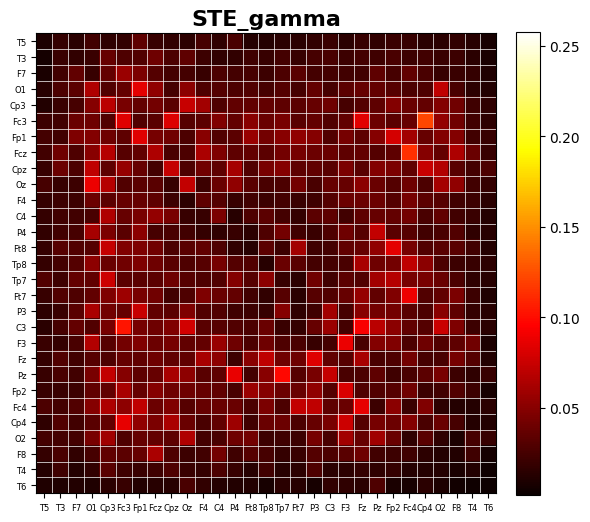

In [33]:
eloc30_path = "../電極通道/BD_MDD_HC_29_test.loc"
eloc30 = mne.channels.read_custom_montage(eloc30_path)
ch_names = eloc30.ch_names  # list of 29 electrode names

# Display each channel (modality × band) with axis labels
# Compute global vmin/vmax for consistent color scale
vmin, vmax = saliency_avg.min(), saliency_avg.max()
for idx in range(18):
    fig, ax = plt.subplots(figsize=(6,6))
    im = ax.imshow(saliency_avg[idx], cmap='hot', aspect='equal', vmin=vmin, vmax=vmax)
    ax.set_title(f"{chan_labels[idx]}", fontsize=16, fontweight='bold')
    # set tick positions and labels: x-axis below, labels upright
    ax.set_xticks(np.arange(29))
    ax.set_yticks(np.arange(29))
    ax.set_xticklabels(ch_names, fontsize=6, rotation=0)
    ax.set_yticklabels(ch_names, fontsize=6)
    # move x-axis labels to bottom and y-axis remains left
    ax.xaxis.set_ticks_position('bottom')
    ax.xaxis.set_label_position('bottom')
    # add grid lines for clarity
    ax.set_xticks(np.arange(-.5, 29, 1), minor=True)
    ax.set_yticks(np.arange(-.5, 29, 1), minor=True)
    ax.grid(which='minor', color='white', linestyle='-', linewidth=0.5)
    ax.tick_params(which='minor', bottom=False, left=False)

    # Add a colorbar with consistent scale
    cbar = fig.colorbar(im, ax=ax, orientation='vertical', fraction=0.046, pad=0.04)
    plt.tight_layout()
    plt.show()

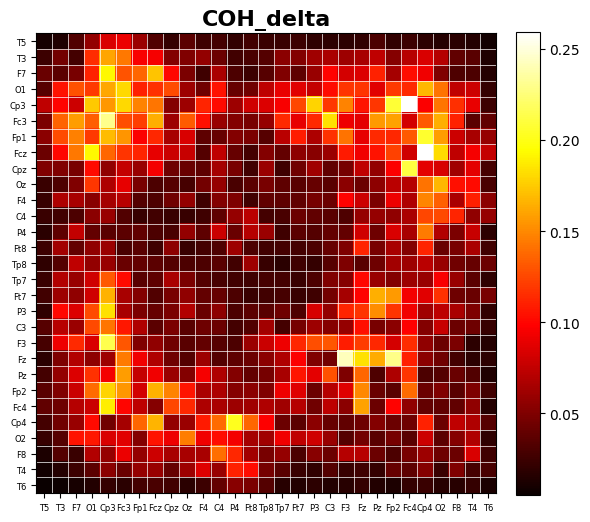

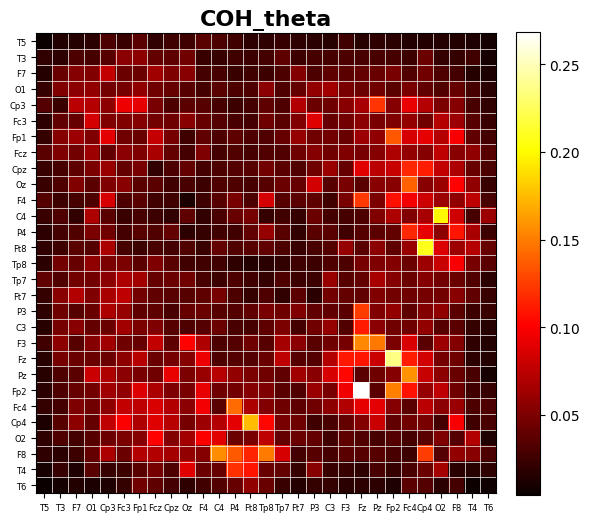

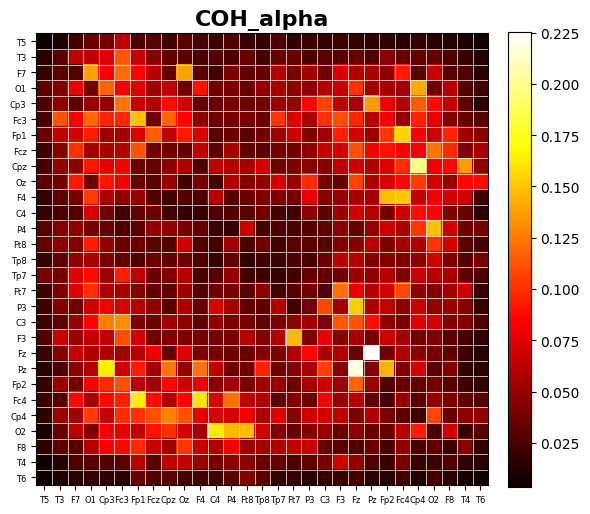

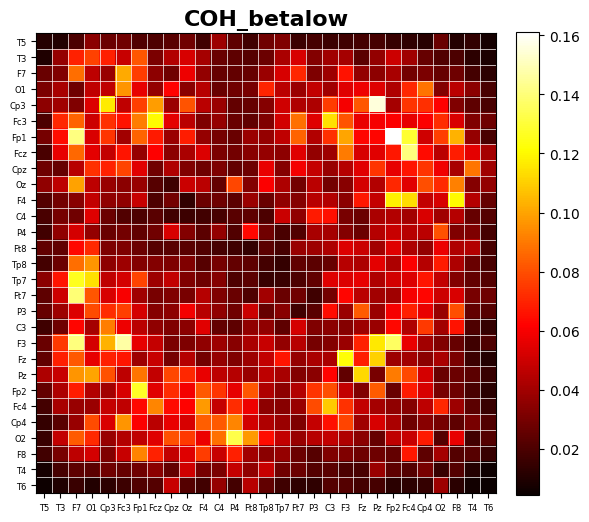

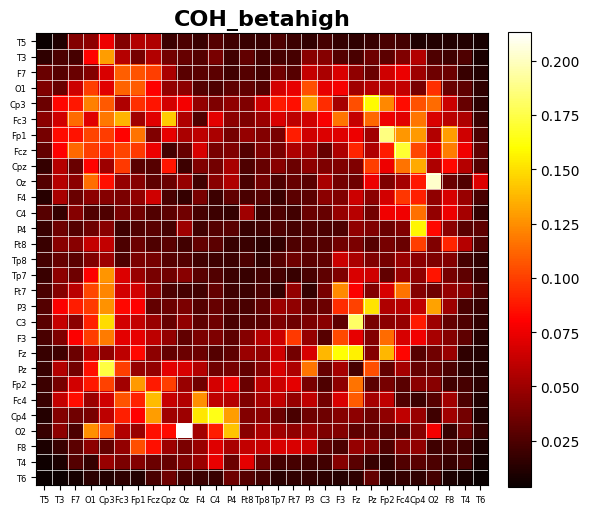

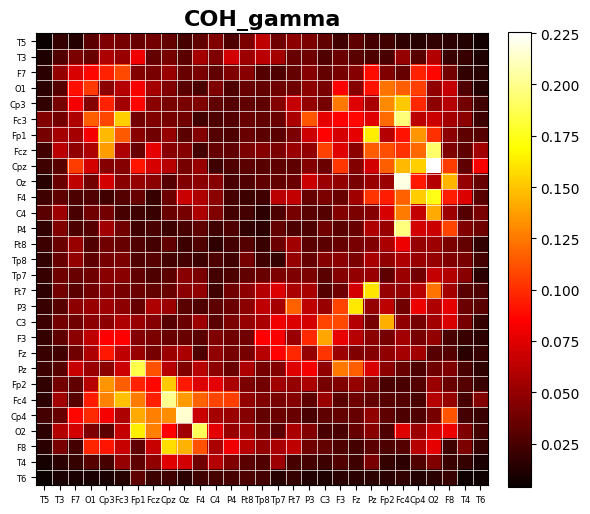

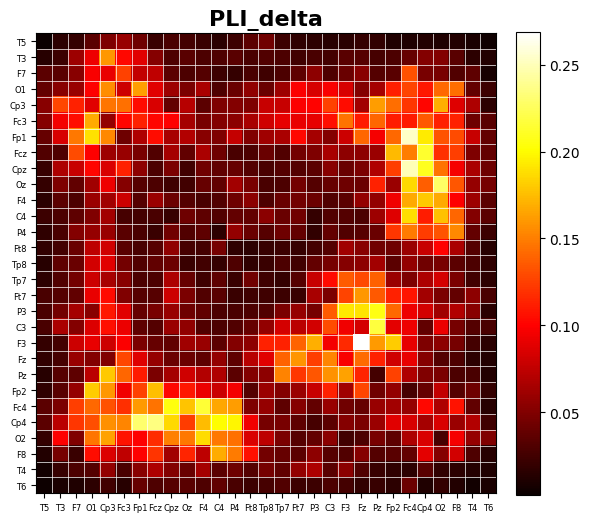

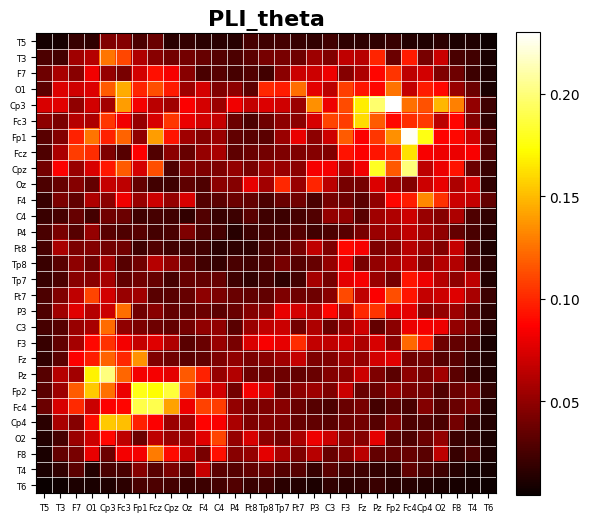

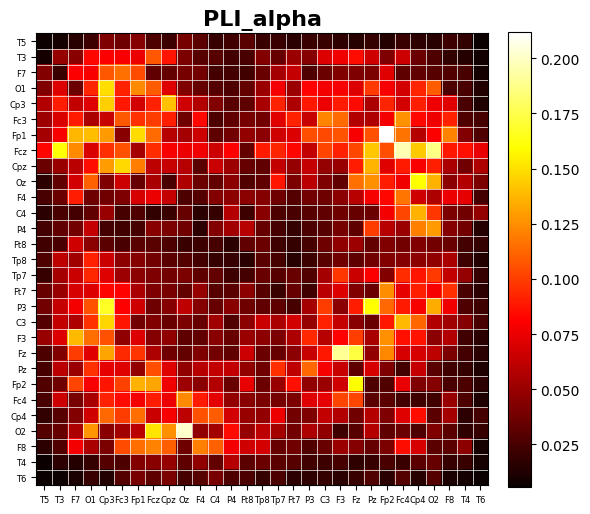

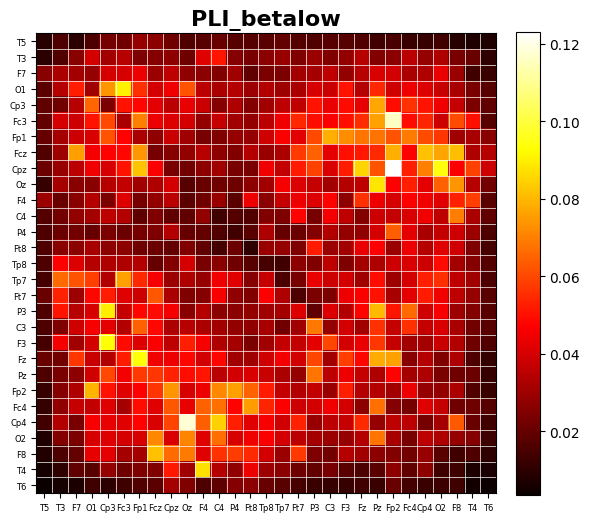

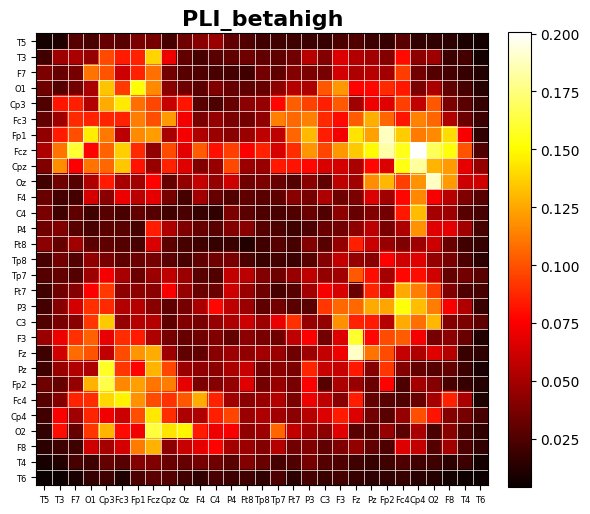

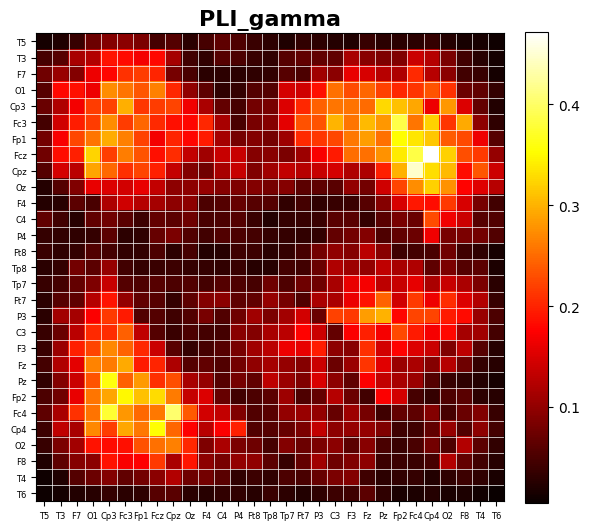

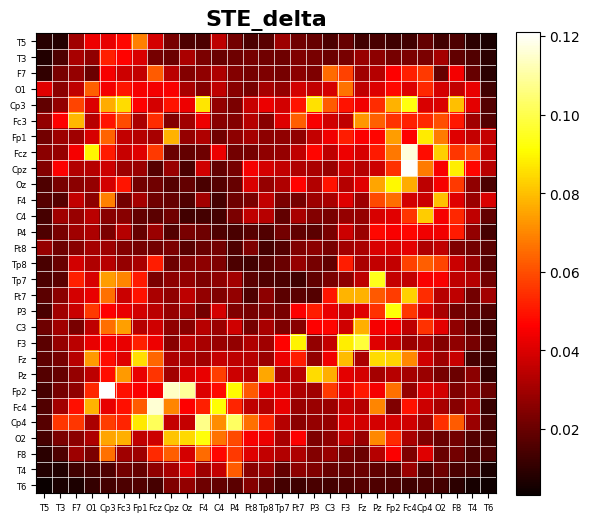

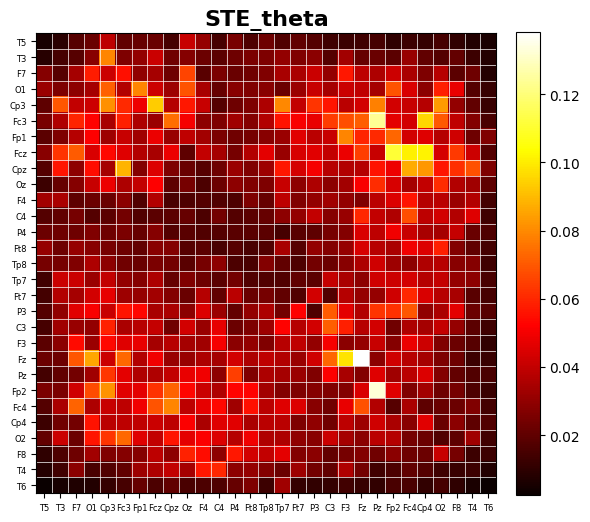

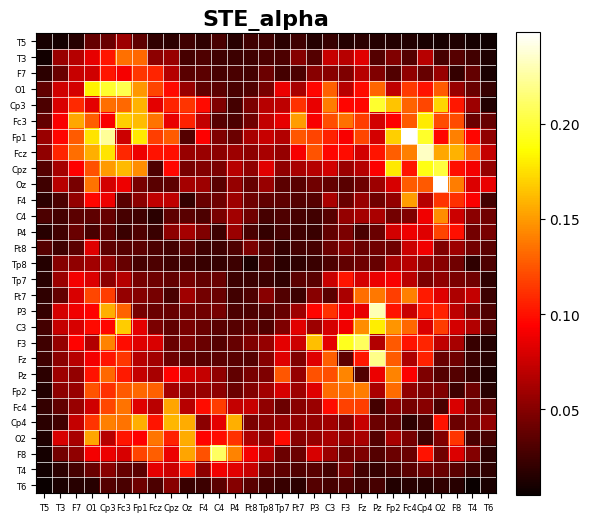

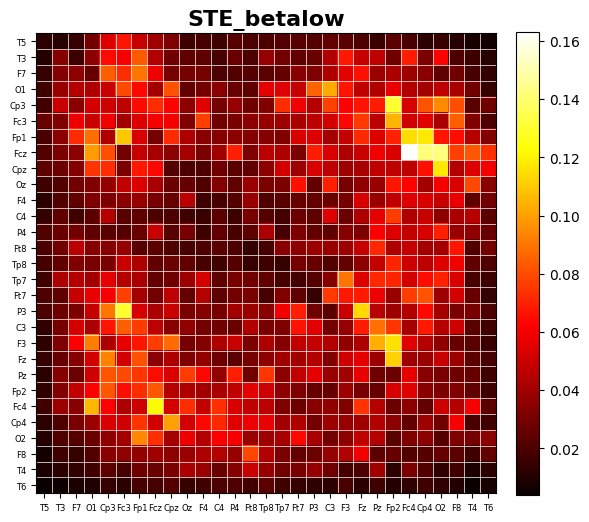

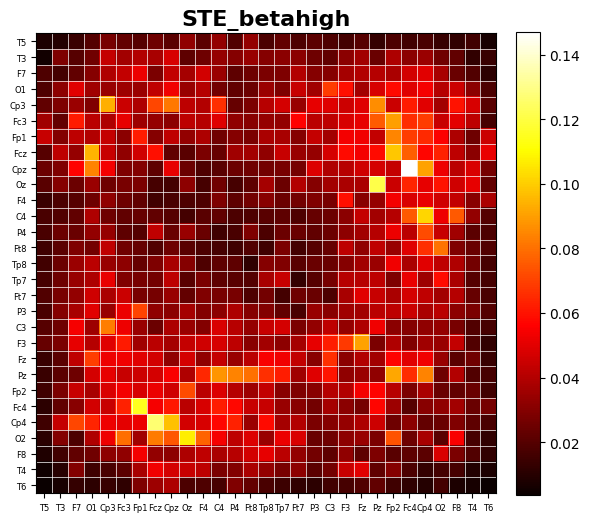

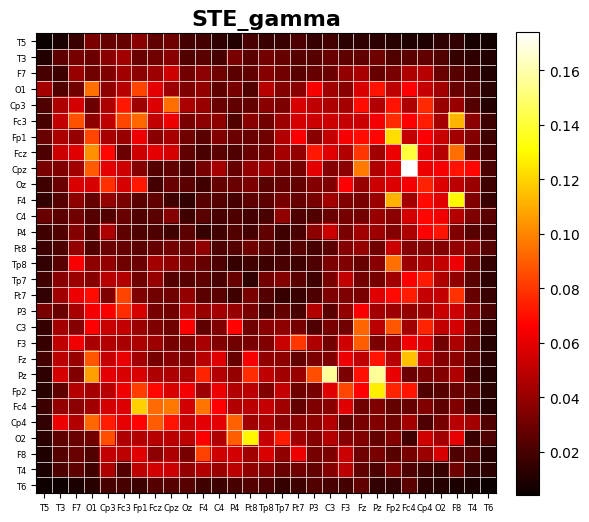

In [11]:
eloc30_path = "../電極通道/BD_MDD_HC_29_test.loc"
eloc30 = mne.channels.read_custom_montage(eloc30_path)
ch_names = eloc30.ch_names  # list of 29 electrode names

# Display each channel (modality × band) with axis labels
for idx in range(18):
    fig, ax = plt.subplots(figsize=(6,6))
    im = ax.imshow(saliency_avg[idx], cmap='hot', aspect='equal')
    ax.set_title(f"{chan_labels[idx]}", fontsize=16, fontweight='bold')
    # set tick positions and labels: x-axis below, labels upright
    ax.set_xticks(np.arange(29))
    ax.set_yticks(np.arange(29))
    ax.set_xticklabels(ch_names, fontsize=6, rotation=0)
    ax.set_yticklabels(ch_names, fontsize=6)
    # move x-axis labels to bottom and y-axis remains left
    ax.xaxis.set_ticks_position('bottom')
    ax.xaxis.set_label_position('bottom')
    # add grid lines for clarity
    ax.set_xticks(np.arange(-.5, 29, 1), minor=True)
    ax.set_yticks(np.arange(-.5, 29, 1), minor=True)
    ax.grid(which='minor', color='white', linestyle='-', linewidth=0.5)
    ax.tick_params(which='minor', bottom=False, left=False)

    # Add a colorbar
    cbar = fig.colorbar(im, ax=ax, orientation='vertical', fraction=0.046, pad=0.04)
    plt.tight_layout()
    plt.show()

##### topomap

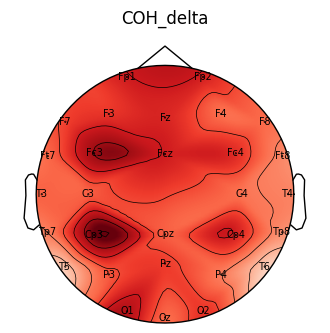

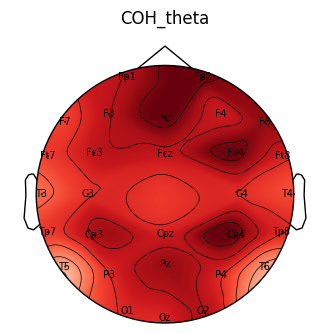

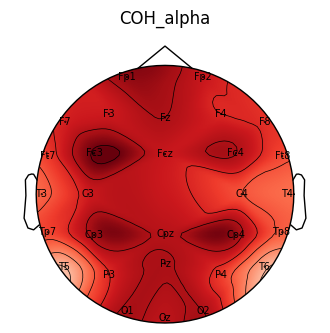

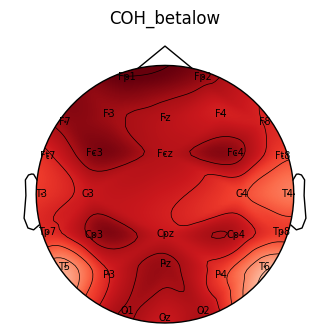

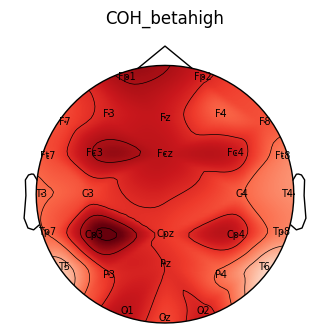

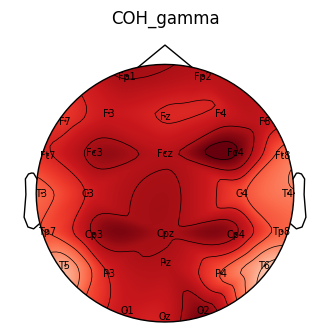

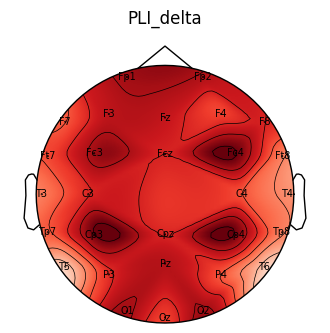

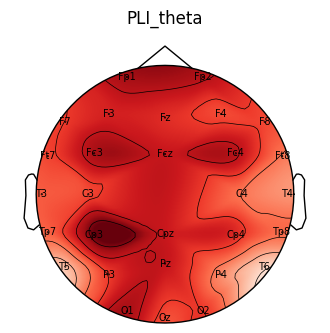

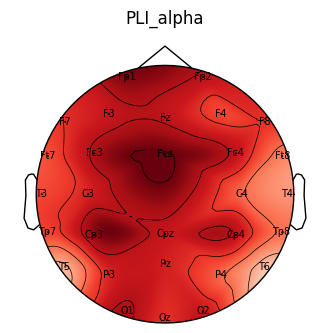

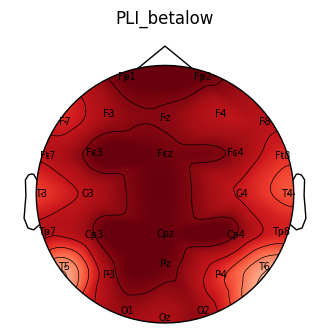

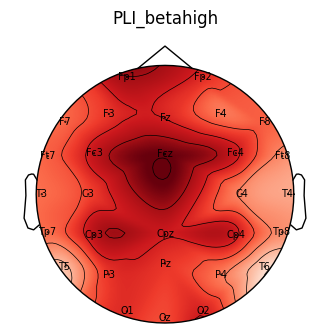

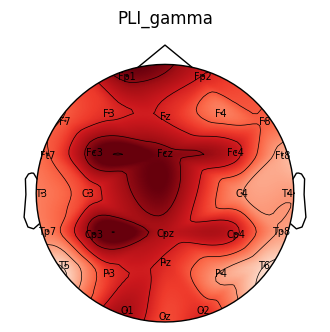

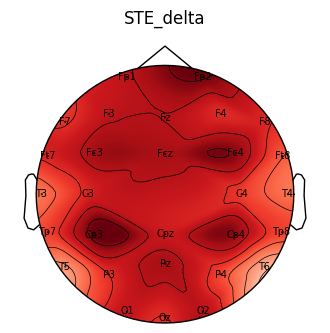

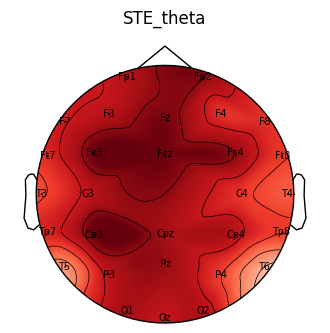

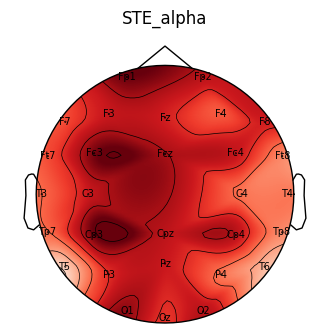

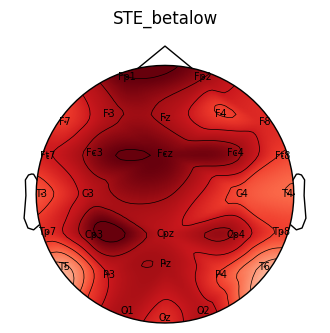

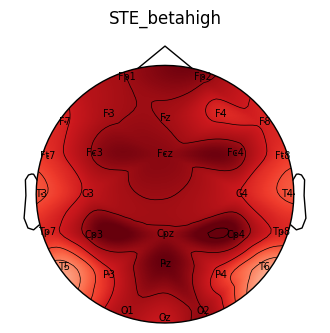

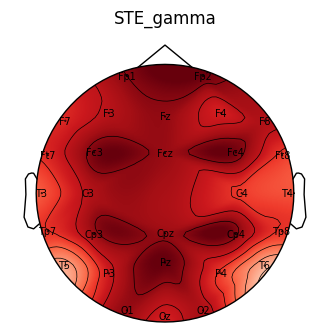

In [ ]:
montage = mne.channels.read_custom_montage('../電極通道/BD_MDD_HC_29_test.loc')
ch_names = montage.ch_names
# extract 2D positions from montage
pos_dict = montage.get_positions()['ch_pos']  # dict {ch_name: (x, y, z)}
pos_arr = np.array([pos_dict[ch][:2] for ch in ch_names])  # shape (29,2)

for idx in range(18):
    # Node importance = sum of saliency map rows+cols
    node_imp = saliency_avg[idx].sum(axis=1) + saliency_avg[idx].sum(axis=0)
    fig = plt.figure(figsize=(4,4))
    mne.viz.plot_topomap(node_imp, pos_arr, names=ch_names,
                         axes=plt.gca(), show=False)
    plt.title(chan_labels[idx])
    plt.show()


##### top 50 features

In [25]:
flat_all = saliency_avg.flatten()
top50_idx = np.argsort(flat_all)[-100:]
# Convert flat indices back to (channel, row, col)
ch_idx, row_idx, col_idx = np.unravel_index(top50_idx, saliency_avg.shape)

# Count per modality and list features
counts = {'COH': 0, 'PLI': 0, 'STE': 0}
features = []
for c, r, co in zip(ch_idx, row_idx, col_idx):
    sal = saliency_avg[c, r, co]
    if c < 6:
        modality = 'COH'
    elif c < 12:
        modality = 'PLI'
    else:
        modality = 'STE'
    band = bands[c % 6]
    if modality == 'STE':
        detail = f"{ch_names[r]} -> {ch_names[co]}"
    else:
        detail = f"{ch_names[r]} - {ch_names[co]}"
    counts[modality] += 1
    features.append((modality, band, detail, sal))

# Print counts
print("Top 50 salient features by modality:")
for mod in ['COH', 'PLI', 'STE']:
    print(f"  {mod}: {counts[mod]} features")

# Print detailed list
print("Detailed top 50 features:")

for mod, bd, det, sal in features:
    print(f"{mod} {bd}: {det} (saliency={sal:.4f})")

Top 50 salient features by modality:
  COH: 9 features
  PLI: 89 features
  STE: 2 features
Detailed top 50 features:
COH betahigh: Fz - F3 (saliency=0.1093)
PLI gamma: Fc3 - Fp2 (saliency=0.1097)
PLI gamma: Cp3 - Fc4 (saliency=0.1098)
COH delta: Fp1 - Fp2 (saliency=0.1101)
PLI gamma: O2 - Cpz (saliency=0.1102)
PLI gamma: F4 - Fz (saliency=0.1106)
PLI alpha: O1 - Cp4 (saliency=0.1106)
PLI alpha: O1 - O2 (saliency=0.1109)
COH delta: Fz - F3 (saliency=0.1114)
PLI gamma: O2 - O1 (saliency=0.1117)
PLI gamma: O1 - Cpz (saliency=0.1117)
PLI gamma: T3 - Fcz (saliency=0.1122)
PLI gamma: Oz - O1 (saliency=0.1124)
PLI gamma: F3 - Fz (saliency=0.1125)
PLI gamma: Fcz - T3 (saliency=0.1128)
PLI gamma: Fp1 - O2 (saliency=0.1129)
PLI gamma: Fp1 - F7 (saliency=0.1129)
PLI gamma: Fz - Fp2 (saliency=0.1134)
PLI alpha: O2 - Cpz (saliency=0.1135)
PLI gamma: Fc4 - Fp1 (saliency=0.1136)
PLI gamma: O1 - P3 (saliency=0.1141)
PLI gamma: P3 - Fz (saliency=0.1146)
PLI gamma: Fcz - Fp1 (saliency=0.1149)
PLI gamma